# Classification metrics: Just how imbalanced is '*imbalanced*'?
**Author: [Carl McBride Ellis](https://www.kaggle.com/carlmcbrideellis)** ([LinkedIn](https://www.linkedin.com/in/carl-mcbride-ellis/))

***In this notebook we shall empirically compare the performance of various [classification metrics](https://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics) on imbalanced data.***

It is often stated that when performing classification it is preferable to have 'balanced' data, and if the data is imbalanced then special techniques should be used. However, just how imbalanced is '*imbalanced*'? In this short notebook we shall create a synthetic dataset consisting of 25000 samples using the Scikit-learn [make_classification](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html) routine having two classes (*i.e. binary classification*). We shall then vary the ratio of the classes and for each case calculate the 
[accuracy_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html),
the [balanced_accuracy_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.balanced_accuracy_score.html), which is given by
the arithmetic mean of sensitivity (true positive rate) and specificity (true negative rate):

$$ {\mathtt{balanced-accuracy}} = \frac{1}{2} \left(\frac{\mathrm{TP}}
{\mathrm{TP}+\mathrm{FN}} + \frac{\mathrm{TN}}
{\mathrm{TN}+\mathrm{FP}}\right)$$

It is worth mentioning that in the limit of a balanced dataset the `balanced_accuracy_score` becomes equivalent to the `accuracy_score`.
We shall also use the [average_precision_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.average_precision_score.html),
the [recall_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html), 
the [f1_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html), which is given by: 

$$ F_1 = 2\frac{precision . recall}{precision + recall}$$

and the [area under the ROC curve](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html), where a score of 0.5 indicates that the classifier has been 'uninformative'.

We use the [StratifiedShuffleSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedShuffleSplit.html) when performing out test/train split, thus preserving the percentage of samples for each class.
For our classification we shall use the Scikit-learn [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html), with nothing other than the default settings. In all cases the splitting criteria used by the estimator, in this case the Gini impurity, remains the same. For more on the Gini impurity see my notebook ["Titanic: some sex, a bit of class, and a tree..."](https://www.kaggle.com/code/carlmcbrideellis/titanic-some-sex-a-bit-of-class-and-a-tree/notebook).

In [1]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier()

In general the [random forest classifier](https://doi.org/10.1023/A:1010933404324) makes for an excellent choice when it comes to creating a baseline score:
 * It effectively has only one adjustable parameter, `max_depth`, where one can control the pruning. If one is careful about the tree depth then:
 * [Random forests does not overfit. You can run as many trees as you want](https://www.stat.berkeley.edu/~breiman/RandomForests/cc_home.htm). So you do not need to worry about the `n_estimators` parameter.
 * They are a non-parametric technique, so there is no need to [rescale the features](https://en.wikipedia.org/wiki/Feature_scaling) beforehand, *i.e.* so that they have [a mean value of 0 and unit variance](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)
 * Also, there is no need [transform the features](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PowerTransformer.html) so as to have a Gaussian distribution
 * No need to perform [categorical feature encoding](https://scikit-learn.org/stable/modules/preprocessing.html#encoding-categorical-features) beforehand (\*)
 * The Random Forest algorithm is resilient to missing data (\*)
 
(\* Note: The scikit-learn implementation of the Random Forest requires [one hot encoding](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) for object types, and does not natively handle missing values)

Later one can then compare the random forest baseline result against more advanced techniques, such as [gradient boosted trees](https://en.wikipedia.org/wiki/Gradient_boosting).
 
## Results

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


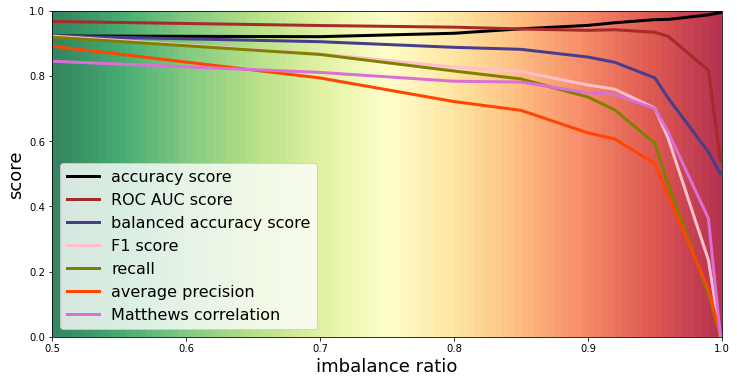

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.colors
import seaborn as sn

from sklearn.metrics import confusion_matrix
from statsmodels.graphics.mosaicplot import mosaic

from sklearn.datasets import make_classification
from sklearn.model_selection import StratifiedShuffleSplit

from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import matthews_corrcoef

def get_acc_and_F1(ratio):
    # create the synthetic dataset
    X, y = make_classification(n_samples=25000, 
                            n_features=20, 
                            n_informative=2, 
                            n_redundant=2, 
                            n_repeated=0, 
                            n_classes=2, 
                            n_clusters_per_class=2, 
                            weights=[ratio, 1-ratio], 
                            flip_y=0.01, 
                            class_sep=1.0, 
                            hypercube=True, 
                            shift=0.0, 
                            scale=1.0, 
                            shuffle=True, 
                            random_state=42)

    # test train split with shuffling
    sss = StratifiedShuffleSplit(n_splits=2, test_size=0.2, random_state=42)

    for train_index, test_index in sss.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
    
    classifier.fit(X_train, y_train)
    predictions = classifier.predict(X_test)
    
    # calculate the metrics
    accuracy     = accuracy_score(y_test, predictions)
    acc_bal      = balanced_accuracy_score(y_test, predictions)
    av_precision = average_precision_score(y_test, predictions)
    recall       = recall_score(y_test, predictions)
    f1           = f1_score(y_test, predictions)
    roc          = roc_auc_score(y_test, classifier.predict_proba(X_test)[:, 1])
    mcc          = matthews_corrcoef(y_test, predictions)

    return(accuracy, acc_bal, av_precision, recall, f1, roc, mcc)

ratios_list        = [0.5, 0.7, 0.8, 0.85, 0.9, 0.92, 0.95, 0.96, 0.99, 0.999]
accuracy_list      = []
bal_accuracy_list  = []
av_precision_list  = []
recall_list        = []
f1_values_list     = []
roc_list           = []
mcc_list           = []

for ratio in ratios_list:
    accuracy, acc_bal, av_precision, recall, f1, roc, mcc = get_acc_and_F1(ratio)
    accuracy_list.append(accuracy)
    bal_accuracy_list.append(acc_bal)
    av_precision_list.append(av_precision)
    recall_list.append(recall)
    f1_values_list.append(f1)
    roc_list.append(roc)
    mcc_list.append(mcc)
    
# now plot
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

ax.plot(ratios_list,accuracy_list,     lw=3, label='accuracy score',          c='black')
ax.plot(ratios_list,roc_list,          lw=3, label='ROC AUC score',           c='brown')
ax.plot(ratios_list,bal_accuracy_list, lw=3, label='balanced accuracy score', c='darkslateblue')
ax.plot(ratios_list,f1_values_list,    lw=3, label='F1 score',                c='pink')
ax.plot(ratios_list,recall_list,       lw=3, label='recall',                  c='olive')
ax.plot(ratios_list,av_precision_list, lw=3, label='average precision',       c='orangered')
ax.plot(ratios_list,mcc_list,          lw=3, label='Matthews correlation',    c='orchid')

ax.set_title("", fontsize=18)
ax.set_xlabel ("imbalance ratio", fontsize=18)
ax.set_ylabel ("score", fontsize=18)
plt.legend(loc="lower left",fontsize=16)

gradient = np.linspace(0.5, 1, 100).reshape(1, -1)
plt.imshow(gradient , extent=[0.5, 1, 0, 1], aspect='auto', cmap='RdYlGn_r', alpha=0.80)

plt.show();

From this plot we can see two things; the first is that up to a ratio of 85%/15% then our classifier metrics are not too bad, whilst beyond 95%:5% things get really bad. And secondly, that the accuracy score is a truly awful metric for gauging how well our classifier is doing, indeed it can even be seen to be going up as things get worse! This has led to some practitioners to call this the '*accuracy paradox*'. At the very least one should use the *balanced* accuracy score.
## kaggle Datasets
These are quite a few [datasets](https://www.kaggle.com/datasets) for binary classification that can be found on kaggle, here are three examples:

## [Titanic](https://www.kaggle.com/c/titanic):

In [3]:
train_data = pd.read_csv('../input/titanic/train.csv')
train_data['Survived'].value_counts().to_frame().T

,0,1
Survived,549,342


we can see that the Titanic data has a roughly 60:40 split, so we can fairly safely treat that dataset as being balanced, and get away with using the accuracy score as a metric.

## [Heart Disease UCI](https://www.kaggle.com/ronitf/heart-disease-uci/):

In [4]:
train_data = pd.read_csv('../input/heart-disease-uci/heart.csv')
train_data['target'].value_counts().to_frame().T

,1,0
target,165,138


we have a 55:45 split, so again, a balanced dataset.

## [Credit Card Fraud Detection](https://www.kaggle.com/mlg-ulb/creditcardfraud/):

In [5]:
train_data = pd.read_csv('../input/creditcardfraud/creditcard.csv')
X = train_data.drop(['Class'], axis = 1)
y = train_data['Class']
y.value_counts().to_frame().T

,0,1
Class,284315,492


Now in this dataset we have a 99.8%:0.2% split, so we are most certainly dealing with imbalanced data. Performing classification on this dataset without first performing resampling would be a disaster; here one has to use techniques such as [SMOTE](https://imbalanced-learn.org/dev/references/generated/imblearn.over_sampling.SMOTE.html), which can be found in the [imbalanced-learn](https://github.com/scikit-learn-contrib/imbalanced-learn) package.
If you are unfamiliar with dealing with imbalanced data may I highly recommend the excellent notebook ["*Credit Fraud || Dealing with Imbalanced Datasets*"](https://www.kaggle.com/janiobachmann/credit-fraud-dealing-with-imbalanced-datasets) written by [Janio Martinez Bachmann](https://www.kaggle.com/janiobachmann).
It is also worth mentioning that the baseline `accuracy_score` for this dataset, obtained by setting all of the predictions simply to be the majority class (this is known as the [Zero Rule](https://machinelearningcatalogue.com/algorithm/alg_zero-rule.html) benchmark) would be `0.998`, clearly not a useful metric to compare against when measuring any improvements.

## Over-sampling the minority class: Very simple SMOTE example
SMOTE is an over-sampling approach in which the minority class is over-sampled by creating "synthetic" examples, rather than say by over-sampling with replacement. 
This is very easy to implement using the [imbalanced-learn](https://github.com/scikit-learn-contrib/imbalanced-learn) package, for [example](https://imbalanced-learn.org/stable/over_sampling.html), using the Credit Card data from above:

In [6]:
from imblearn.over_sampling import SMOTE
X_resampled, y_resampled = SMOTE().fit_resample(X, y)

resulting now in a balanced dataset

In [7]:
y_resampled.value_counts().to_frame().T

,0,1
Class,284315,284315


### What does SMOTE do?
Here is a scatter plot of an imbalanced dataset 

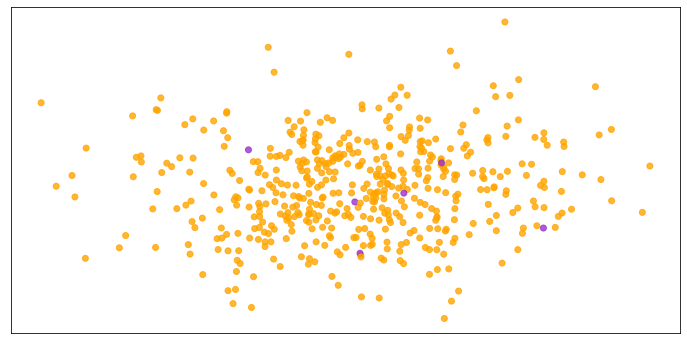

In [8]:
X, y = make_classification(n_samples=500, 
                            n_classes=2,
                            n_features=2,
                            n_informative=2, 
                            n_redundant=0, 
                            n_repeated=0,
                            weights=[0.99, 1-0.99],
                            class_sep=0.3,
                            random_state=2)

# define the colours to use
my_cmap = matplotlib.colors.ListedColormap(['orange', 'darkorchid'])
# now make a scatter plot
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=my_cmap, alpha=0.8)
# hide the labels
plt.xticks([])
plt.yticks([])
plt.show();

we can see that there are six points in the dataset from the minority class. 

We now apply the SMOTE resampling

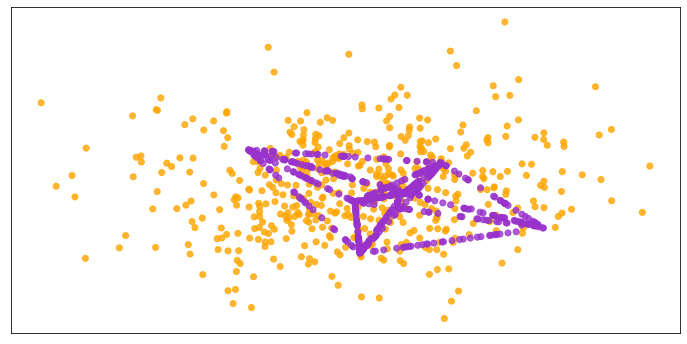

In [9]:
X_resampled, y_resampled = SMOTE().fit_resample(X, y)
# now plot again
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
plt.scatter(X_resampled[:, 0], X_resampled[:, 1], c=y_resampled, cmap=my_cmap, alpha=0.8)
plt.xticks([])
plt.yticks([])
plt.show();

We can see that what SMOTE does is create new synthetic data points which are situated randomly along line segments that connect existing minority class points.

# Under-sampling the majority class
Under-sampling the majority class has the advantage of speeding up training time, at has been mentioned in a number of publications that doing this has been found to have little negative impact on the model score. Indeed, under-sampling was a technique used by the winners of the kaggle [TalkingData AdTracking Fraud Detection Challenge](https://www.kaggle.com/c/talkingdata-adtracking-fraud-detection/discussion/56475).

A naïve way to perform under sampling using pandas (here keeping only 5% of the majority class `0`) is simply

In [10]:
undersample = pd.concat([train_data[train_data['Class']==1], 
                         train_data[train_data['Class']==0].sample(frac=0.05, random_state=42)])

# now randomly shuffle the dataframe rows in order to mix up the classes again
undersample = undersample.sample(frac=1, random_state=42)

which can be useful for testing purposes. However, see  [imbalanced-learn](https://imbalanced-learn.org/stable/) for more sophisticated methods.

## "...60% of the time it works *every* time"
It is worth mentioning that over and under-sampling are not without their problems. If the classes are not well-separable then re-sampling can simply add more noise to the data. And if the classes are well-separable, then resampling may not be needed at all. Indeed the age-old data-balancing mantra in certain cases can actually do more harm than good, and the following two blog posts are well worth reading:

* [Why Balancing Classes is Over-Hyped](https://towardsdatascience.com/why-balancing-classes-is-over-hyped-e382a8a410f7)
* [Your Dataset Is Imbalanced? Do Nothing!](https://towardsdatascience.com/your-dataset-is-imbalanced-do-nothing-abf6a0049813)


# Conclusion
Each dataset has to be taken on its own merits, and just how imbalanced is "imbalanced" will also depend on the technique and package that you are using to perform the classification. For example, XGBoost has `scale_pos_weight`,  CatBoost has `class_weights` and LightGBM has `pos_bagging_fraction` (see the corresponding documentation for more details).
However, as a rough guide, if the data is imbalanced by more than 85:15 then from the point of view of classification metrics resampling should definitely be used. Furthermore, I would advise against ever using the (unbalanced) accuracy score as a classification metric.
# Related reading
* ["Balanced accuracy score"](https://scikit-learn.org/stable/modules/model_evaluation.html#balanced-accuracy-score)
* ["F1 score"](https://en.wikipedia.org/wiki/F-score) on Wikipedia
* ["ROC curve"](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) on Wikipedia
* Other Scikit-learn [classification metrics](https://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics)
* ["Oversampling and undersampling in data analysis"](https://en.wikipedia.org/wiki/Oversampling_and_undersampling_in_data_analysis) on Wikipedia
* [imbalanced-learn documentation](https://imbalanced-learn.org/stable/)
* [Probability calibration](https://scikit-learn.org/stable/modules/calibration.html) for when using probabilities rather than class labels

### **See also:**
* [Nitesh V. Chawla, Kevin W. Bowyer, Lawrence O. Hall, W. Philip Kegelmeyer "*SMOTE: Synthetic Minority Over-sampling Technique*", Journal of Artificial Intelligence Research vol **16** pp. 321-357 (2002)](https://www.jair.org/index.php/jair/article/view/10302/24590)
* [Chen Wang, Chengyuan Deng, Suzhen Wang "*Imbalance-XGBoost: leveraging weighted and focal losses for binary label-imbalanced classification with XGBoost*", Pattern Recognition Letters vol. **136** pp. 190-197 (2020)](https://doi.org/10.1016/j.patrec.2020.05.035)
* [Qiuming Zhu "*On the performance of Matthews correlation coefficient (MCC) for imbalanced dataset*", Pattern Recognition Letters vol. **136** pp. 71-80 (2020)](https://doi.org/10.1016/j.patrec.2020.03.030)
* [Alexandru Niculescu-Mizil, Rich Caruana "*Predicting Good Probabilities With Supervised Learning*", ICML '05: Proceedings of the 22nd international conference on Machine learning pp, 625-632 (2005)](https://doi.org/10.1145/1102351.1102430)